# TP1 - Parte B: Classificação de Atividades Humanas 
### Tópicos de Ciência dos Dados - MECD (2022/2023)

### Autores

- Duarte Meneses - 2019216949
- Patricia Costa - 2019213995


In [19]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

## 4.5 e 4.6 da Parte A

## Parte B


### 1.1. Data Splitting

### 1.1.1. Train-Test (TT) e Train-Validation-Test data split

In [37]:
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

def train_test(data, target, train_size):

    x_train, x_test, y_train, y_test = train_test_split(data, target, train_size=train_size)

    trainTest = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]}

    return trainTest

def train_validation_test(data, target, train_size, test_size):

    x_train, x_rem, y_train, y_rem = train_test_split(data, target, train_size=train_size)

    # 1 - train_size -> correponde agora ao nosso 100%(1)
    # test_size -> test_size / (1-train_size)

    test = test_size / (1-train_size)

    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = test)

    trainValidation = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test], "Validation": [x_valid, y_valid]}
    
    return trainValidation



### 1.1.2. K-fold data split

In [21]:
from sklearn.model_selection import KFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

def k_fold(x, y, n_splits, shuffle = False, random_state = None):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    kfold = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        kfold.append({"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]})
    
    return kfold

In [22]:
#Testes
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

print("--Train Test--\n")
trainTest = train_test(X, y, 0.7)
display(trainTest)

print("\n--Train Validation Test--\n")
trainValidation = train_validation_test(X, y, 0.4, 0.3)
display(trainValidation)

print("\n--K Fold--\n")
kFold = k_fold(X, y, 4)
display(kFold)

--Train Test--



{'TRAIN': [array([[1, 2],
         [3, 4]]),
  array([1, 2])],
 'TEST': [array([[1, 2],
         [3, 4]]),
  array([3, 4])]}


--Train Validation Test--



{'TRAIN': [array([[1, 2]]), array([1])],
 'TEST': [array([[1, 2],
         [3, 4]]), array([3, 4])],
 'Validation': [array([[3, 4]]), array([2])]}


--K Fold--



[{'TRAIN': [array([[3, 4],
          [1, 2],
          [3, 4]]),
   array([2, 3, 4])],
  'TEST': [array([[1, 2]]), array([1])]},
 {'TRAIN': [array([[1, 2],
          [1, 2],
          [3, 4]]),
   array([1, 3, 4])],
  'TEST': [array([[3, 4]]), array([2])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [3, 4]]),
   array([1, 2, 4])],
  'TEST': [array([[1, 2]]), array([3])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [1, 2]]),
   array([1, 2, 3])],
  'TEST': [array([[3, 4]]), array([4])]}]

### 1.2. Métricas de exactidação

In [23]:
#Teste
true = [2, 0, 2, 2, 0, 1]
pred = [0, 0, 2, 2, 0, 2]

-> Explicação do parâmetro average

**'binary'**:
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

**'micro'**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.

**'macro'**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**'weighted'**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**'samples'**:
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

Confusion Matrix:
 [[2 0 0]
 [0 0 1]
 [1 0 2]]

Recall:  0.6666666666666666

Precision:  0.5555555555555555

F1-score:  0.6
--------------------------------------------------


,0,1,2
0,2,0,0
1,0,0,1
2,1,0,2


,Metrics
Recall,0.666667
Precision,0.555556
F1-score,0.600000


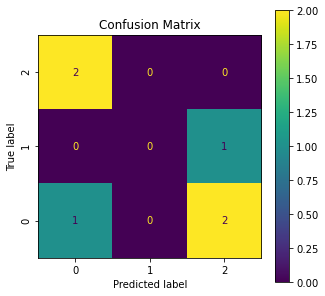

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
from sklearn.metrics import precision_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
from sklearn.metrics import f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

def metrics(true, pred):
    cm = confusion_matrix(true, pred)
    rs = recall_score(true, pred, average='weighted', zero_division=0)
    ps = precision_score(true, pred, average='weighted', zero_division=0)
    f1 = f1_score(true, pred, average='weighted', zero_division=0)

    print('Confusion Matrix:\n', cm)
    print('\nRecall: ', rs)
    print('\nPrecision: ', ps)
    print('\nF1-score: ', f1)
    print('-'*50)

    return [cm, rs, ps, f1]

def mais_bonito(cm, rs, ps, f1, labels):

    cmFrame = pd.DataFrame(cm, columns=labels, index=labels).style.set_caption("Confusion Matrix")
    display(cmFrame)

    cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
    _, ax = plt.subplots(figsize=(5,5))
    cmp.plot(ax=ax)
    ax.set_title("Confusion Matrix")
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels[::-1], rotation=90)

    metricsFrame = pd.DataFrame([rs, ps, f1], columns=['Metrics']).rename(index={0: 'Recall', 1: 'Precision', 2: 'F1-score'})
    display(metricsFrame)
    

cm, rs, ps, f1 = metrics(true, pred)
mais_bonito(cm, rs, ps, f1, [0,1,2])



### 2.1. Dataset

In [32]:
iris = datasets.load_iris()

data = iris.data
target = iris.target

### 2.1. k-Nearest Neighbours

Confusion Matrix:
 [[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]

Recall:  1.0

Precision:  1.0

F1-score:  1.0
--------------------------------------------------


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


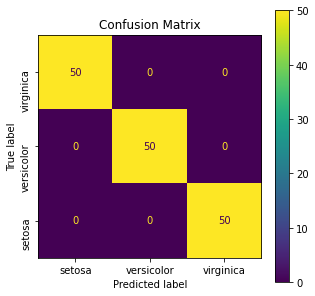

In [33]:
from sklearn.neighbors import KNeighborsClassifier

def K_neighbors_classifier(x, y, k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x, y)

    return neigh

neigh_teste = K_neighbors_classifier(data, target, 1)

#TESTE - APAGAR
def ex211_T0(x, y, labels):
    k = 1
    model = K_neighbors_classifier(x, y, k)
    pred = model.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)
    mais_bonito(cm, rs, ps, f1, labels)
    
ex211_T0(data, target, iris["target_names"])

### 2.1.1. Train-only, TT 70-30

Nota: o resultados da matriz de confusáo deveria ser 3x3 e dá 2x2, não percebo

Confusion Matrix:
 [[16  0  0]
 [ 0 10  1]
 [ 0  1 17]]

Recall:  0.9555555555555556

Precision:  0.9555555555555556

F1-score:  0.9555555555555556
--------------------------------------------------


,setosa,versicolor,virginica
setosa,16,0,0
versicolor,0,10,1
virginica,0,1,17


,Metrics
Recall,0.955556
Precision,0.955556
F1-score,0.955556


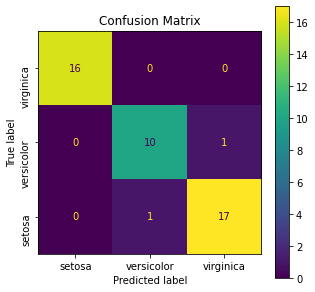

In [40]:
def TT_211(x, y, labels, k):
    trainTest = train_test(x, y, 0.7)
    neigh = K_neighbors_classifier(trainTest['TRAIN'][0], trainTest['TRAIN'][1], k)
    pred = neigh.predict(trainTest['TEST'][0])
    true = trainTest['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TT_211(data, target, iris["target_names"], 1)

### 2.1.1. 10x10-fold cross-validation (10CV)

In [41]:
def CV10(x, y, n_splits, labels, k):
    kf = k_fold(x, y, n_splits)

    count = 0
    for info in kf:
        print("------------------- Iteração " + str(count) + " -------------------")
        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)
        mais_bonito(cm, rs, ps, f1, labels)

        count += 1

CV10(data, target, 10, iris["target_names"], 1)

------------------- Iteração 0 -------------------
Confusion Matrix:
 [[15]]

Recall:  1.0

Precision:  1.0

F1-score:  1.0
--------------------------------------------------


ValueError: Shape of passed values is (1, 1), indices imply (3, 3)